### 0. Librerias 

In [1]:
#! pip install pandas numpy seaborn matplotlib

In [2]:
#! pip install dython

In [3]:
! pip list

Package                 Version
----------------------- -----------
alembic                 1.15.1
appnope                 0.1.4
asttokens               3.0.0
cloudpickle             3.1.1
colorlog                6.9.0
comm                    0.2.2
contourpy               1.3.1
cycler                  0.12.1
debugpy                 1.8.13
decorator               5.2.1
dython                  0.7.9
executing               2.2.0
fonttools               4.56.0
imbalanced-learn        0.13.0
imblearn                0.0
ipykernel               6.29.5
ipython                 9.0.1
ipython_pygments_lexers 1.1.1
jedi                    0.19.2
joblib                  1.4.2
jupyter_client          8.6.3
jupyter_core            5.7.2
kiwisolver              1.4.8
lightgbm                4.6.0
llvmlite                0.44.0
Mako                    1.3.9
MarkupSafe              3.0.2
matplotlib              3.10.1
matplotlib-inline       0.1.7
nest-asyncio            1.6.0
numba                   0

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import shap


/Users/familiaperdomobocachica2/Documentos MAC/Clase_MLOPS_K/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Carge de los datos 

In [49]:
df = pd.read_csv('../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [50]:
# Get the basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [51]:
columnas = df.columns

### Descriptivos basicos 

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 1.3 Variable obetivo 

In [9]:
df['Churn'].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

### Casteo de variables 

In [10]:
df['TotalCharges'] = df['TotalCharges'].replace('', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

In [11]:
# cobertir dado de numero a categorico
df['SeniorCitizen'] = df['SeniorCitizen'].astype('str')

In [12]:
# Convert the target variable to a binary numeric variable
df['ChurnTarget'] = df['Churn'].apply(lambda x: 1 if x=='Yes' else 0)
df['ChurnTarget'].value_counts(normalize=True)

ChurnTarget
0    0.73463
1    0.26537
Name: proportion, dtype: float64

### 3. Feature Selection

3.1 Seleccion de variables numericas 

In [13]:
target = 'ChurnTarget'
num_features = df.select_dtypes(include=[np.number]).columns.drop(target)

# Calculate correlations
correlations = df[num_features].corrwith(df[target])

# Set a threshold for feature selection
threshold = 0.3
selected_num_features = correlations[abs(correlations) > threshold].index.tolist()
print(selected_num_features)

['tenure']


3.2 seleccion de variables categoricas 

3.3 vaeriables finales para modelamiento 

In [14]:
selected_cat_features= ['tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod']

In [15]:
selected_features = []
selected_features.extend(selected_num_features)
selected_features.extend(selected_cat_features)

print(selected_features)

['tenure', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod']


### 4 Modeling 

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
from sklearn.model_selection import train_test_split

target = 'ChurnTarget' 

X = df[selected_features]
y = df[target]

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(include=['number']).columns.tolist()

#Splitting data into Train, Validation, and Test Set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=45, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=45, stratify=y_train_val)

In [18]:
from dython.nominal import associations

In [19]:
if 'ChurnTarget' not in cat_features:
    cat_features.append('ChurnTarget')

assoc = associations(df[cat_features], nominal_columns='all', plot=False)
corr_matrix = assoc['corr']

threshold = 0.3
selected_cat_features = corr_matrix[corr_matrix.loc['ChurnTarget'] > threshold].index.tolist()
del selected_cat_features[-1]

print(selected_cat_features)


['InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod']


In [20]:
categorical_target = 'ChurnTarget'

assoc = associations(df[cat_features], nominal_columns='all', plot=False)
corr_matrix = assoc['corr']

threshold = 0.3
selected_cat_features = corr_matrix[corr_matrix.loc[categorical_target] > threshold ].index.tolist()

del selected_cat_features[-1]

print(selected_cat_features)

['InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaymentMethod']


In [21]:
X_train = X_train.loc[:, ~X_train.columns.duplicated()]


In [22]:
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [23]:
X_val = X_val.loc[:, ~X_val.columns.duplicated()]

In [24]:
if 'ChurnTarget' in cat_features:
    cat_features.remove('ChurnTarget')

In [25]:
print(X_train.columns)
print(y_train.name)


Index(['tenure', 'InternetService', 'OnlineSecurity', 'TechSupport',
       'Contract', 'PaymentMethod'],
      dtype='object')
ChurnTarget


In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
# Prepare the preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the logistic regression model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['tenure', 'tenure']),
                                                 ('cat', OneHotEncoder(),
                                                  ['InternetService',
                                                   'OnlineSecurity',
                                                   'TechSupport', 'Contract',
                                                   'PaymentMethod'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [27]:
from sklearn.metrics import classification_report

# Evaluate on the validation set
y_val_pred = pipeline.predict(X_val)
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate on the test set
y_test_pred = pipeline.predict(X_test)
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.55      0.58       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409

Test Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.86      1035
           1       0.61      0.54      0.57       374

    accuracy                           0.79      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.79      0.78      1409



### RANDOM FOREST

#### Definición de Variables Predictorias y Objetivo

#### Eliminar customer ID

In [28]:
df = df.drop(columns=["customerID"])

In [29]:
df = df.drop(columns=["Churn"])

In [30]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnTarget
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [31]:
df["ChurnTarget"].value_counts()

ChurnTarget
0    5174
1    1869
Name: count, dtype: int64

In [32]:
df = pd.get_dummies(df, drop_first=True)

In [33]:
df.head()

,tenure,MonthlyCharges,TotalCharges,ChurnTarget,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [34]:
X = df.drop("ChurnTarget", axis=1)
y = df["ChurnTarget"]

#### Porcentaje de clientes que hace Churn

In [35]:
print(f"Porcentaje de churn positivo: {y.mean():.2%}")

Porcentaje de churn positivo: 26.54%


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45, stratify=y)

In [37]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

#### Modelo Random Forest Classifier

In [38]:
df.head()

,tenure,MonthlyCharges,TotalCharges,ChurnTarget,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,False,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,34,56.95,1889.50,0,True,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,2,53.85,108.15,1,True,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,45,42.30,1840.75,0,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,2,70.70,151.65,1,False,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [39]:

print('🔄 Randomized Search iniciado...')
param_dist = {
    'n_estimators': [100, 200, 300], 
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2'], 
    'class_weight': ['balanced', 'balanced_subsample'], 
    'bootstrap': [True] 
}

rscv = RandomizedSearchCV(RandomForestClassifier(random_state=45), param_distributions=param_dist,
                          n_iter=20, cv=3, scoring='roc_auc', random_state=45, n_jobs= 1, verbose=1)
rscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Random Search):", rscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, rscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rscv.predict(X_test)))


🔄 Randomized Search iniciado...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🏁 Mejor configuración (Random Search): {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
🔍 AUC test: 0.8373003840711541
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1552
           1       0.53      0.75      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.80      0.75      0.77      2113



#### Modelo Random Forest Classifier AJUSTADO

In [40]:

print('🔄 Randomized Search iniciado...')
param_dist = {
    'n_estimators': [100, 300], 
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt', 'log2'], 
    'class_weight': ['balanced'], 
    'bootstrap': [True] 
}

rscv = RandomizedSearchCV(RandomForestClassifier(random_state=45), param_distributions=param_dist,
                          n_iter=20, cv=3, scoring='roc_auc', random_state=45, n_jobs= 1, verbose=1)
rscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Random Search):", rscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, rscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rscv.predict(X_test)))

🔄 Randomized Search iniciado...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
🏁 Mejor configuración (Random Search): {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
🔍 AUC test: 0.8367203723101238
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1552
           1       0.53      0.76      0.62       561

    accuracy                           0.76      2113
   macro avg       0.71      0.76      0.72      2113
weighted avg       0.80      0.76      0.77      2113



#### Modelo GridSearchCV

In [41]:

print('🔄 Grid Search iniciado...')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'class_weight': ['balanced'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gscv = GridSearchCV(RandomForestClassifier(random_state=45), param_grid=param_grid,
                    scoring='roc_auc', cv=3, n_jobs= 1, verbose=1)
gscv.fit(X_train, y_train)

print("🏁 Mejor configuración (Grid Search):", gscv.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, gscv.predict_proba(X_test)[:,1]))
print(classification_report(y_test, gscv.predict(X_test)))

🔄 Grid Search iniciado...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
🏁 Mejor configuración (Grid Search): {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
🔍 AUC test: 0.8361116470955767
              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1552
           1       0.53      0.73      0.62       561

    accuracy                           0.76      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.79      0.76      0.77      2113



#### Modelo Bayesiana

In [42]:

print('🔄 Bayesian Optimization iniciado...')
opt_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 5),
    'max_features': Categorical(['sqrt', 'log2']),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'bootstrap': Categorical([True]) 
}

bsearch = BayesSearchCV(RandomForestClassifier(random_state=45),
                        search_spaces=opt_space,
                        n_iter=20,
                        scoring='roc_auc',
                        cv=3,
                        n_jobs= 1,
                        verbose=1,
                        random_state=45)
bsearch.fit(X_train, y_train)

print("🏁 Mejor configuración (Bayesian Search):", bsearch.best_params_)
print("🔍 AUC test:", roc_auc_score(y_test, bsearch.predict_proba(X_test)[:,1]))
print(classification_report(y_test, bsearch.predict(X_test)))

🔄 Bayesian Optimization iniciado...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for 

In [43]:

print('🔁 Aplicando SMOTE...')
smote = SMOTE(random_state=45)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

rf_sm = RandomForestClassifier(**rscv.best_params_, random_state=45)
rf_sm.fit(X_train_sm, y_train_sm)

print("✅ Resultados con SMOTE")
print("🔍 AUC test:", roc_auc_score(y_test, rf_sm.predict_proba(X_test)[:,1]))
print(classification_report(y_test, rf_sm.predict(X_test)))


🔁 Aplicando SMOTE...
✅ Resultados con SMOTE
🔍 AUC test: 0.8346317557013432
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1552
           1       0.58      0.63      0.61       561

    accuracy                           0.78      2113
   macro avg       0.72      0.74      0.73      2113
weighted avg       0.79      0.78      0.79      2113



📊 Visualizaciones iniciadas...


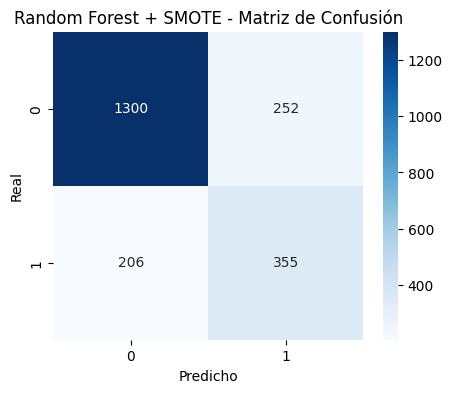

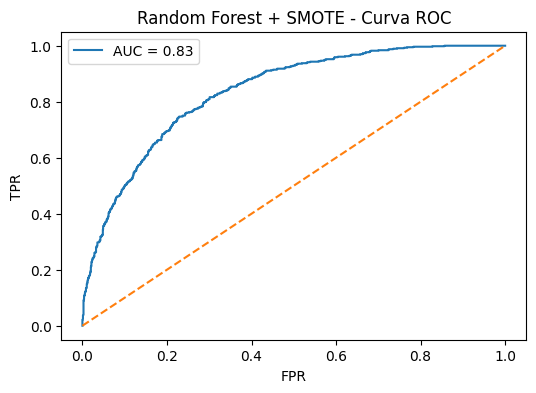

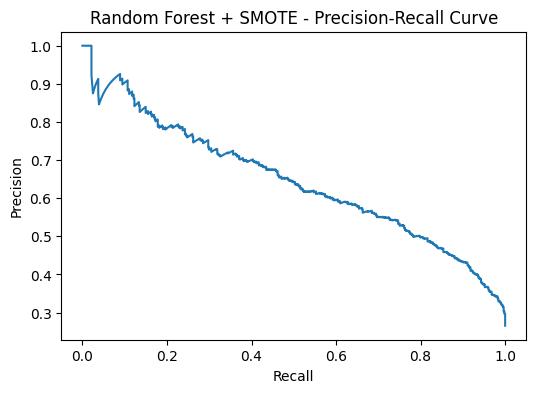

In [54]:
print('📊 Visualizaciones iniciadas...')
def plot_model_performance(model, X_test, y_test, model_name="Modelo"):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{model_name} - Matriz de Confusión")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f"{model_name} - Curva ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()



plot_model_performance(rf_sm, X_test, y_test, model_name="Random Forest + SMOTE")


🧠 Interpretabilidad con SHAP...


 99%|===================| 4204/4226 [02:22<00:00]        

<Figure size 640x480 with 0 Axes>

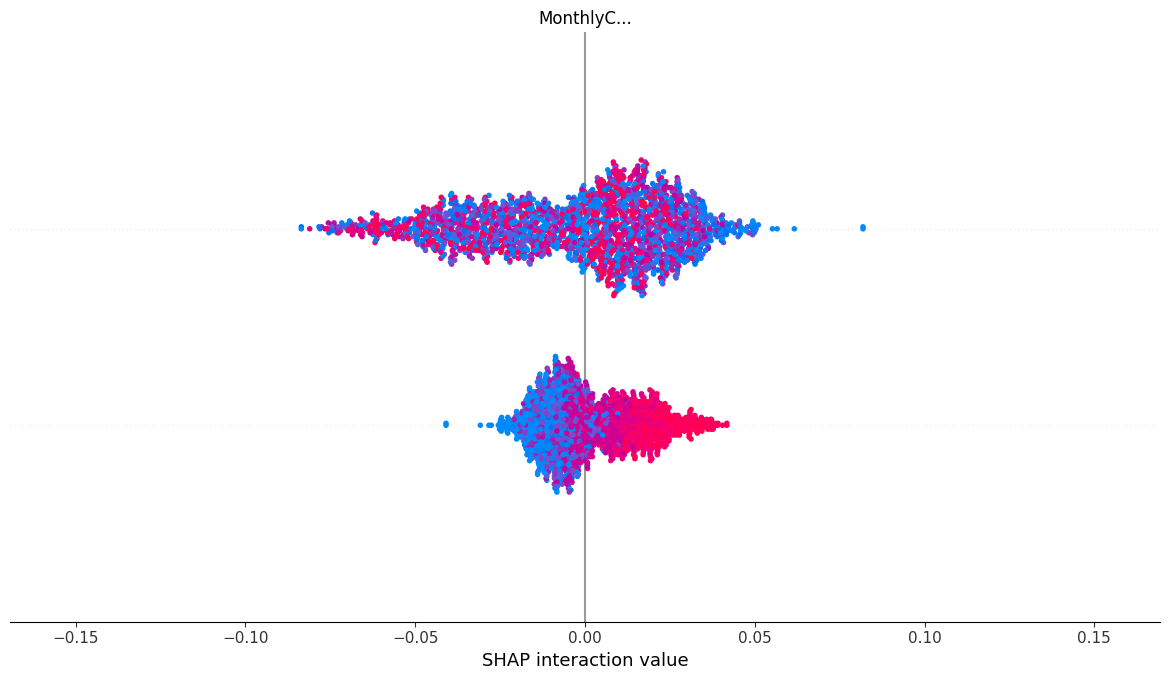

<Figure size 640x480 with 0 Axes>

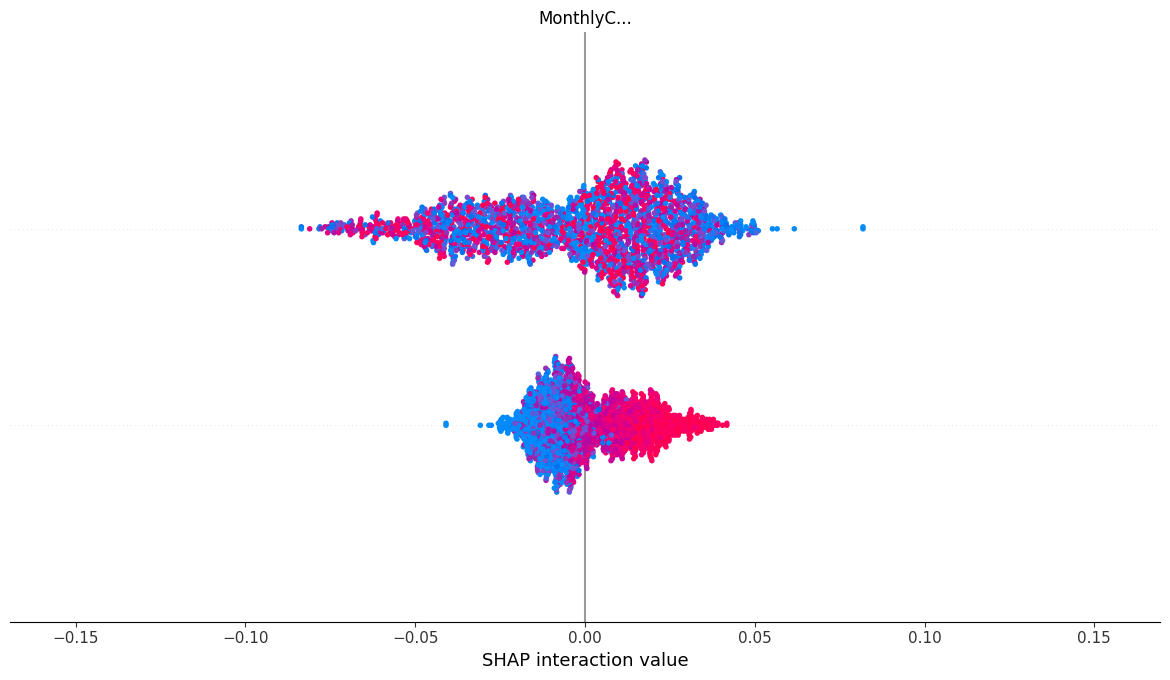

In [ ]:
print('🧠 Interpretabilidad con SHAP...')
explainer = shap.Explainer(rf_sm, X_train, feature_names=X.columns)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_test, show=True)
